In [1]:
from functions import *

train_ft = pd.read_csv('pump_data/training_set_features.csv')
train_labels = pd.read_csv('pump_data/training_set_labels.csv')
xtrain, xtest, ytrain, ytest = train_test_split(train_ft, train_labels, random_state=17)
ytest = ytest['status_group']

# merge them for EDA purposes
df = xtrain.merge(ytrain, on='id')

# a numeric version of our target
df['status_group_numeric'] = df['status_group'].map(lambda x: 1 if x == 'functional' else -1 if x == 'non functional' else 0)

## Building a Model

After looking through the rest of the data as well and cleaning things up, we landed on the following set of features.

In [2]:
features = ['amount_tsh', 'funder', 'management', 'management_group', 'installer', 'public_meeting', 'gps_height', 'longitude', 'latitude', 'basin', 'district_code', 'permit', 'extraction_type_class', 'payment', 'quality_group', 'quantity', 'waterpoint_type_group','region', 'construction_year']

categorical_features = ['quantity', 'public_meeting', 'basin', 'district_code', 'permit', 'extraction_type_class', 'payment', 'management', 'management_group', 'water_quality', 'quality_group', 'waterpoint_type_group', 'region', 'construction_year', 'funder', 'installer']

numerical_features = ['amount_tsh', 'gps_height', 'longitude', 'latitude']

xtrain_ft = df[features]
ytrain = df['status_group']


Each of these features seemed to have a decent correlation with a well's functionality. Other features were excluded for being redundant (there were three separate columns each related to extraction methods) or for having too much noise (there were several hundred different subvillages). 

Our next step was to decide what kind of model to use, as well as what kind of metric to use in scoring. The terms of the competition specify accuracy as the metric, so that decision was more or less made for us. The decision regarding the kind of model to use was a little trickier.

A few options could be ruled out easily. We couldn't use Naive Bayes, for example, because our features were not independent. Similarly, a logistic regression model would be difficult to justify because there would be severe multicollinearity among our features. This left a number of other options, but after a bit of trial and error it seemed that Random Forests would be the most promising. That said, the final goal would be to combine different model types to build an ensemble model.

Our initial Random Forest model can be found below.

In [6]:
# this pipeline works on our Cleaner class, which automates many of the cleaning steps described above, and gets dummies for categorical variables
forest_pipeline = Pipeline(steps=[
    ('cleaner', Cleaner()),
    ('randforest', RandomForestClassifier(),)
])

forest_pipeline.fit(xtrain_ft, ytrain)


forest_pipeline.score(xtest[features], ytest)

0.7927946127946128

79% accuracy for an untuned first pass seemed promising, especially as the winning score for the competition is 82%. Let's take a look at a confusion matrix.

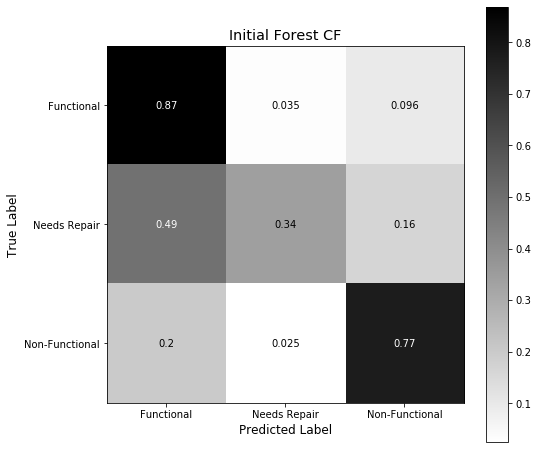

In [7]:
plot_pretty_cf(forest_pipeline, xtest[features], ytest, cmap='binary', normalize='true', title='Initial Forest CF')

As the confusion matrix shows, our model did pretty well in labelling functional wells, a little worse with regard to non-functional wells, and quite poorly with regard to wells that need repair. This could be due to a class imbalance problem, since the 'needs repair' category represents only about 6% of the data (compare 54.6% for functional and 38.5% for non functional).

To correct this error, we try the same model but this time using SMOTE to correct for class imbalance.

In [8]:
forest_pipeline_SMOTE = Pipeline(steps=[
    ('cleaner', Cleaner()),
    ('SMOTE', SMOTE()),
    ('randforest', RandomForestClassifier(),)
])

forest_pipeline_SMOTE.fit(xtrain_ft, ytrain)


forest_pipeline_SMOTE.score(xtest[features], ytest)

0.7802693602693602

Using SMOTE here actually reduced our accuracy. As the confusion matrix below shows, it did this while also not greatly improving our ability to detect when a well needed repairs. So we will not use SMOTE in our final model.

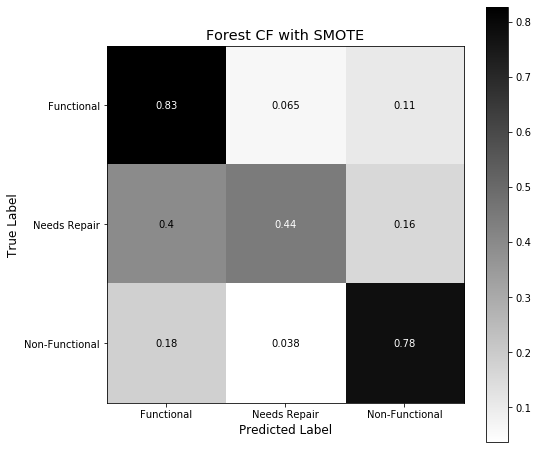

In [9]:
plot_pretty_cf(forest_pipeline_SMOTE, xtest[features], ytest, cmap='binary', normalize='true', title='Forest CF with SMOTE')

Our next step was to try out different parameters to see if we could tune our model and improve it. For that we used a gridsearch.

In [13]:
forest_param_grid = {
    'randforest__n_estimators': [200, 250],
    'randforest__max_depth': [6, 8, None],
    'randforest__min_samples_split': [9, 10, 11],
    'randforest__min_samples_leaf': [2, 3],
    'randforest__max_features': [0.25, 0.1]
}

forest_gscv = GridSearchCV(forest_pipeline, param_grid=forest_param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

forest_gscv.fit(xtrain_ft, ytrain)

best_model = forest_gscv.best_estimator_
best_model.score(xtest[features], ytest)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 13.4min finished


0.800942760942761

Just over 80%! Looks good. Let's get the parameters for our model. 

In [14]:
best_model.get_params(deep=True)

{'memory': None,
 'steps': [('cleaner', Cleaner()),
  ('randforest',
   RandomForestClassifier(max_features=0.25, min_samples_leaf=2,
                          min_samples_split=9, n_estimators=250))],
 'verbose': False,
 'cleaner': Cleaner(),
 'randforest': RandomForestClassifier(max_features=0.25, min_samples_leaf=2,
                        min_samples_split=9, n_estimators=250),
 'cleaner__columns': None,
 'randforest__bootstrap': True,
 'randforest__ccp_alpha': 0.0,
 'randforest__class_weight': None,
 'randforest__criterion': 'gini',
 'randforest__max_depth': None,
 'randforest__max_features': 0.25,
 'randforest__max_leaf_nodes': None,
 'randforest__max_samples': None,
 'randforest__min_impurity_decrease': 0.0,
 'randforest__min_impurity_split': None,
 'randforest__min_samples_leaf': 2,
 'randforest__min_samples_split': 9,
 'randforest__min_weight_fraction_leaf': 0.0,
 'randforest__n_estimators': 250,
 'randforest__n_jobs': None,
 'randforest__oob_score': False,
 'randforest__rando

One thing we can do here is check which parameters were at the upper or lower bounds of the grid search and then run another grid search with the parameters bent a bit in that direction. Here the number of estimators is at the upper limit; let's push it farther and see if we can get a better model. Other parameters seem close to the center, but let's tweak those as well. 

In [15]:
forest_param_grid2 = {
    'randforest__n_estimators': [200, 250, 300],
    'randforest__min_samples_split': [8, 9, 10],
    'randforest__min_samples_leaf': [1, 2],
    'randforest__max_features': [0.4, 0.25]
}

forest_gscv2 = GridSearchCV(forest_pipeline, param_grid=forest_param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

forest_gscv2.fit(xtrain_ft, ytrain)

best_model2 = forest_gscv.best_estimator_
best_model2.score(xtest[features], ytest)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 13.0min finished


0.800942760942761

This score is identical to that of our last model. A look at the parameters confirms that they are the same. It was good to experiment, but the model did not want to go down the new paths we opened for it.

In [17]:
best_model2.get_params(deep=True)

{'memory': None,
 'steps': [('cleaner', Cleaner()),
  ('randforest',
   RandomForestClassifier(max_features=0.25, min_samples_leaf=2,
                          min_samples_split=9, n_estimators=250))],
 'verbose': False,
 'cleaner': Cleaner(),
 'randforest': RandomForestClassifier(max_features=0.25, min_samples_leaf=2,
                        min_samples_split=9, n_estimators=250),
 'cleaner__columns': None,
 'randforest__bootstrap': True,
 'randforest__ccp_alpha': 0.0,
 'randforest__class_weight': None,
 'randforest__criterion': 'gini',
 'randforest__max_depth': None,
 'randforest__max_features': 0.25,
 'randforest__max_leaf_nodes': None,
 'randforest__max_samples': None,
 'randforest__min_impurity_decrease': 0.0,
 'randforest__min_impurity_split': None,
 'randforest__min_samples_leaf': 2,
 'randforest__min_samples_split': 9,
 'randforest__min_weight_fraction_leaf': 0.0,
 'randforest__n_estimators': 250,
 'randforest__n_jobs': None,
 'randforest__oob_score': False,
 'randforest__rando